## Bibliotecas

In [43]:
%matplotlib inline

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pca import pca

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

from quickda.explore_data import *
from quickda.clean_data import *
from quickda.explore_numeric import *
from quickda.explore_categoric import *
from quickda.explore_numeric_categoric import *
from quickda.explore_time_series import *

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

sns.set_style('whitegrid')
sns.set_context('notebook')

import warnings
warnings.filterwarnings('ignore')


## Funções Auxiliares

In [2]:
def percentual_outlier(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    minimum = Q1 - (1.5 * IQR)
    maximum = Q3 + (1.5 * IQR)
    num_outliers =  np.sum((data < minimum) | (data > maximum))
    num_total = data.count()
    return (num_outliers/num_total)*100

def calculate_wcss(data, num):
        wcss = []
        for n in range(2, num):
            kmeans = KMeans(n_clusters=n)
            kmeans.fit(X=data)
            wcss.append(kmeans.inertia_)
    
        return wcss
    
def calculate_silhouete(data, num):
        silhouete_avg = []
        for n in range(2, num):
            kmeans = KMeans(n_clusters=n)
            kmeans.fit(X=data)
            cluster_labels = kmeans.labels_
            silhouete_avg.append(silhouette_score(data, cluster_labels))
    
        return silhouete_avg

def spider_plot_unico(data, cluster):
    means = data.groupby('kmeans').mean().to_numpy()
    names = data.columns[0:-1]
    label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(names))
    categories = np.arange(0, len(means))
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection="polar")
    ax.plot(label_loc, means[cluster], label=f'class {categories[cluster]}')
    ax.set_title(f'Cluster {cluster}', size=20)
    lines, labels = plt.thetagrids(np.degrees(label_loc), labels=names)
    plt.show()
    
def spider_plot(data):
    means = data.groupby('kmeans').mean().to_numpy()
    names = data.columns[0:-1]
    label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(names))
    categories = np.arange(0, len(means))
    fig = plt.figure(figsize=(14,14))
    ax = fig.add_subplot(projection="polar")
    for i in range(len(means)):
        ax.plot(label_loc, means[i], label=f'class {categories[i]}')
        ax.set_title(f'Cluster {i}', size=20)
    lines, labels = plt.thetagrids(np.degrees(label_loc), labels=names)
    plt.legend(loc="lower left")
    plt.show()
    
def spider_plot_YYY(data, cluster):
    means = data.groupby('kmeans').mean().to_numpy()
    names = data.columns[0:-1]
    means = np.c_[means, np.zeros(5)]
    names = np.r_[names, ['']]
    label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(names))
    categories = np.arange(0, len(means))
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(projection="polar")
    #for i in range(len(means)):
    ax.plot(label_loc, means[cluster], label=f'class {categories[cluster]}')
    ax.set_title(f'Cluster {cluster}', size=20)
    lines, labels = plt.thetagrids(np.degrees(label_loc), labels=names)
    #plt.legend(loc="lower left")
    plt.show()    
    

# Carregando os Dados

## Vamos utilizar nesta análise a base montada no notebook de análise inicial do dados. Neste banco já estamos com os dados de DRE preenchidos e não temos dados nulos referentes a informações do DRE.

In [3]:

df = pd.read_csv("./dados_analise_cluster.csv")

In [4]:
explore(df)

,dtypes,count,null_sum,null_pct,nunique,min,25%,50%,75%,max,mean,median,std,skew
anoFundacao,float64,6012,0,0.000,64,1000.0,2000.0,2009.0,2014.0,2020.0,2005.571025,2009.0,17.479035,-32.157992
ativoCirculante,float64,6012,0,0.000,1794,-17.0,529853.0,3230248.0,13960113.0,29038320000.0,39651462.462409,3230248.0,419804345.273875,56.791138
capitalSocial,float64,6012,0,0.000,296,0.0,95400.0,200000.0,800000.0,4100000000.0,11238712.395376,200000.0,94048613.884539,21.749373
cnpjSemTraco,object,6012,0,0.000,1523,AADG56617962174727,-,-,-,ZZVU59020803434073,-,-,-,-
custos,float64,6010,2,0.000,1690,-346633805.0,0.0,2171507.0,12744094.0,4393536000.0,45022236.062396,2171507.0,273814988.466991,12.44144
dashboardCorrelacao,float64,6012,0,0.000,519,-0.99999,0.0,0.0,0.0,0.99999,0.037182,0.0,0.499997,-0.016924
dataAprovadoEmComite,object,443,5569,0.926,443,-,-,-,-,-,-,-,-,-
dataAprovadoNivelAnalista,object,4652,1360,0.226,4652,-,-,-,-,-,-,-,-,-
definicaoRisco,object,6012,0,0.000,4,De 0 a 10 % - Muito Baixo,-,-,-,De 51 a 80 % - Alto,-,-,-,-
diferencaPercentualRisco,float64,6012,0,0.000,77,0.207547,0.679245,0.785714,0.857143,1.0,0.772923,0.785714,0.137616,-0.328264


# Retirando as colunas que não iremos usar na análise de clusters

## Entendemos que a análise requisitada pela empresa WTC é para classificarmos os seus clientes em grupos com características comuns. Para tanto não necessitamos das informações da própria empresa, pois nestes dados já existe um julgamento da mesma sobre estes clientes.

In [5]:
df.drop(['valorAprovado', 'valorSolicitado', 'dataAprovadoEmComite', 'dataAprovadoNivelAnalista', 'percentualProtestos', 'numero_solicitacao', 'prazoMedioRecebimentoVendas',
         'razaoSocial', 'nomeFantasia', 'anoFundacao', 'status', 'definicaoRisco', 'diferencaPercentualRisco', 'dashboardCorrelacao', 'passivoCirculante', 'ativoCirculante',
         'periodoBalanco', 'primeiraCompra', 'intervaloFundacao', 'periodoDemonstrativoEmMeses', 'margemBruta'], axis=1, inplace=True)

## Vamos retirar todos os CNPJs duplicados pois queremos formar clusters com CNPJs únicos

In [6]:
df.drop_duplicates(subset='cnpjSemTraco', keep='last', inplace=True)

In [7]:
explore(df)

,dtypes,count,null_sum,null_pct,nunique,min,25%,50%,75%,max,mean,median,std,skew
capitalSocial,float64,1523,0,0.0,284,0.0,80000.0,150000.0,600000.0,4100000000.0,16456989.209455,150000.0,148810322.700614,18.615678
cnpjSemTraco,object,1523,0,0.0,1523,AADG56617962174727,-,-,-,ZZVU59020803434073,-,-,-,-
custos,float64,1523,0,0.0,1033,-431401.0,0.0,1565850.0,8736359.0,4393536000.0,41907151.246225,1565850.0,259906490.869125,12.264157
duplicatasAReceber,float64,1523,0,0.0,1042,-22780710.0,0.0,567455.0,3720666.0,20093580000.0,24822958.860801,567455.0,521426494.008655,37.596093
empresa_MeEppMei,bool,1523,0,0.0,2,False,0.0,0.0,1.0,True,0.317137,0.0,0.465514,0.786671
endividamento,float64,1523,0,0.0,636,0.0,0.0,0.0,410269.0,740631476.0,4856513.224557,0.0,41701795.15084,14.833408
estoque,float64,1523,0,0.0,1105,0.0,8667.5,605595.0,3524299.0,1293428000.0,12406042.209455,605595.0,76143119.300072,12.38494
faturamentoBruto,float64,1523,0,0.0,1415,0.0,1672928.5,4925896.0,21466386.0,6426115000.0,75644114.824688,4925896.0,408985281.988176,10.747186
limiteEmpresaAnaliseCredito,float64,1523,0,0.0,861,0.0,9900.0,72600.0,585091.0,1974261312.0,4148168.915955,72600.0,53040069.932933,34.071223
maiorAtraso,int64,1523,0,0.0,153,0,0.0,5.0,20.0,977,23.12541,5.0,60.989945,7.656628


In [56]:
df_num = df.drop(['cnpjSemTraco'], axis=1)

## Transformando as variáveis booleanas em númericas. 

In [57]:

#df_num.restricoes = df_num.restricoes.apply(lambda x:1 if x else 0)
#df_num.empresa_MeEppMei = df_num.empresa_MeEppMei.apply(lambda x:1 if x else 0)
df_num.drop(['restricoes', 'empresa_MeEppMei', 'scorePontualidade'], axis=1, inplace=True)


In [58]:
explore(df_num)

,dtypes,count,null_sum,null_pct,nunique,min,25%,50%,75%,max,mean,median,std,skew
maiorAtraso,int64,1523,0,0.0,153,0.0,0.000,5.000,2.000000e+01,9.770000e+02,2.312500e+01,5.000,6.099000e+01,7.657
margemBrutaAcumulada,float64,1523,0,0.0,1200,0.0,0.220,0.387,4.950000e-01,1.000000e+00,3.400000e-01,0.387,2.110000e-01,-0.448
titulosEmAberto,float64,1523,0,0.0,563,0.0,0.000,0.000,9.940000e+03,2.836656e+06,4.092816e+04,0.000,1.765397e+05,8.188
percentualRisco,float64,1523,0,0.0,63,0.0,0.143,0.214,3.040000e-01,6.610000e-01,2.220000e-01,0.214,1.190000e-01,0.635
totalAtivo,float64,1523,0,0.0,1180,0.0,364756.000,2846875.000,1.291962e+07,5.482350e+10,9.602702e+07,2846875.000,1.512397e+09,32.449
totalPatrimonioLiquido,float64,1523,0,0.0,1166,-186719734.0,49100.500,1101916.000,5.735235e+06,1.292328e+10,3.247566e+07,1101916.000,4.124506e+08,26.956
endividamento,float64,1523,0,0.0,636,0.0,0.000,0.000,4.102690e+05,7.406315e+08,4.856513e+06,0.000,4.170180e+07,14.833
duplicatasAReceber,float64,1523,0,0.0,1042,-22780710.0,0.000,567455.000,3.720666e+06,2.009358e+10,2.482296e+07,567455.000,5.214265e+08,37.596
estoque,float64,1523,0,0.0,1105,0.0,8667.500,605595.000,3.524299e+06,1.293428e+09,1.240604e+07,605595.000,7.614312e+07,12.385
faturamentoBruto,float64,1523,0,0.0,1415,0.0,1672928.500,4925896.000,2.146639e+07,6.426115e+09,7.564411e+07,4925896.000,4.089853e+08,10.747


In [59]:
fig = px.box(data_frame = df_num, height=600, title='Banco de Dados Original')
fig.show()

## Como podemos ver no Boxplot acima temos diversos valores outliers. Como iremos fazer uma análise de clusterização que leva em conta as distancias entre os dados estes outliers podem atrapalhar o resultado final, pois no gráfico nem é possível ver o boxplot corretamente.<BR>
## Para visualizarmos melhor vamos calcular o percentual de dados acima e abaixo dos limites inferior e superior, respctivamente, do gráfico boxplot.

In [60]:
for coluna in df_num.columns:
    data = df_num[coluna]
    perc = str(round(percentual_outlier(data), 2))
    print(f'Outliers na coluna {coluna} : {perc}%')

Outliers na coluna maiorAtraso : 11.1%
Outliers na coluna margemBrutaAcumulada : 0.13%
Outliers na coluna titulosEmAberto : 17.07%
Outliers na coluna percentualRisco : 1.12%
Outliers na coluna totalAtivo : 13.72%
Outliers na coluna totalPatrimonioLiquido : 13.99%
Outliers na coluna endividamento : 18.25%
Outliers na coluna duplicatasAReceber : 14.71%
Outliers na coluna estoque : 13.13%
Outliers na coluna faturamentoBruto : 14.31%
Outliers na coluna custos : 15.5%
Outliers na coluna capitalSocial : 15.56%
Outliers na coluna limiteEmpresaAnaliseCredito : 16.74%


In [61]:
mmsc = MinMaxScaler().fit(df_num)
df_mmsc = pd.DataFrame(mmsc.transform(df_num), columns=df_num.columns)
df_mmsc

,maiorAtraso,margemBrutaAcumulada,titulosEmAberto,percentualRisco,totalAtivo,totalPatrimonioLiquido,endividamento,duplicatasAReceber,estoque,faturamentoBruto,custos,capitalSocial,limiteEmpresaAnaliseCredito
0,0.002047,0.000000,0.000000,0.428353,0.000008,0.014256,0.000000,0.001132,0.000155,0.000097,0.000000,0.000010,0.000005
1,0.007165,0.387733,0.003655,0.428353,0.000011,0.014278,0.000000,0.001139,0.000164,0.000183,0.000098,0.000012,0.000022
2,0.019447,0.000000,0.000000,0.485467,0.000013,0.014349,0.000000,0.001165,0.000000,0.000194,0.000595,0.000024,0.000084
3,0.028659,0.000000,0.000000,0.542580,0.000087,0.014585,0.000000,0.001292,0.000924,0.000835,0.000570,0.000122,0.000098
4,0.000000,0.385918,0.000000,0.428353,0.000017,0.014277,0.000000,0.001132,0.000479,0.000089,0.000098,0.000020,0.000032
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1518,0.004094,0.536739,0.002399,0.378378,0.000370,0.014387,0.000101,0.001693,0.004421,0.020740,0.020278,0.000203,0.003647
1519,0.018424,0.374573,0.031830,0.216216,0.000103,0.014312,0.001697,0.001305,0.001018,0.000760,0.000682,0.000007,0.000030
1520,0.000000,0.462250,0.000000,0.405405,0.000000,0.014243,0.000000,0.001132,0.000000,0.000839,0.001269,0.000027,0.000002
1521,0.065507,0.426652,0.449989,0.216216,0.000746,0.016196,0.000062,0.001917,0.011786,0.018627,0.018559,0.000488,0.005487


<AxesSubplot:>

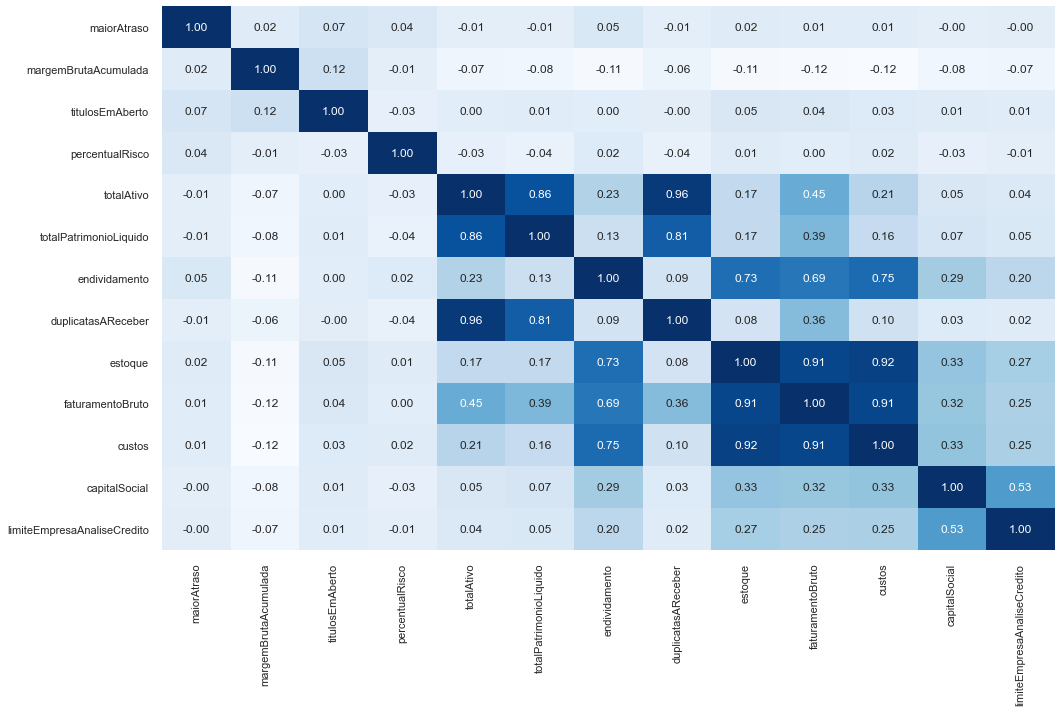

In [62]:
fig = plt.figure(figsize=(16,10))
sns.heatmap(df_mmsc.corr(), cmap='Blues', annot=True, cbar=False, fmt='0.2f')

# PCA

In [64]:
pca = PCA(n_components=13, svd_solver='full', random_state=42)
pca.fit(df_mmsc)
PCA_labels = ['PC'+str(x) for x in range(1,len(pca.components_)+1)]
df_pca = pd.DataFrame(pca.transform(df_mmsc), columns=PCA_labels)
df_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
0,-0.340251,0.078908,-0.052003,-0.014997,0.013951,-0.003235,-0.004250,0.000379,-0.000038,0.000779,-0.001024,-0.000810,0.000164
1,0.045438,0.092967,-0.016694,-0.020920,0.003055,-0.000186,-0.001214,0.001482,0.000151,0.000254,0.000340,-0.000736,0.000009
2,-0.342222,0.136277,-0.051912,-0.002131,0.003895,-0.001962,-0.003484,-0.000487,-0.000191,0.000285,-0.000628,-0.000807,0.000079
3,-0.344276,0.193500,-0.051422,0.004455,-0.000897,-0.000764,-0.002832,-0.001279,-0.000318,0.000930,-0.000758,-0.000866,0.000088
4,0.043457,0.092804,-0.017040,-0.028691,0.004900,-0.000479,-0.001320,0.001576,0.000191,0.000570,0.000363,-0.000907,0.000045
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1518,0.193131,0.048492,0.020747,-0.029578,-0.000797,0.001868,-0.000479,-0.008748,0.001694,-0.011690,0.000388,0.005035,-0.001421
1519,0.040782,-0.119439,-0.012805,0.007729,0.013583,-0.002826,-0.003422,0.003133,0.000639,-0.000238,0.000124,-0.000905,-0.000045
1520,0.120099,0.072639,-0.009207,-0.030962,0.002407,-0.000110,-0.000990,0.001501,0.000114,-0.000648,0.000764,-0.000490,-0.000113
1521,0.106114,-0.119871,0.035097,0.308960,0.301842,-0.003895,-0.004519,0.005025,0.004342,-0.012124,0.003598,0.001411,-0.001721


In [65]:
n_pcs = pca.n_components
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = df_mmsc.columns
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}
df_teste = pd.DataFrame(dic.items(), columns=['Component', 'Feature'])
df_teste['Variance'] = np.round(pca.explained_variance_ratio_*100, 2)
df_teste['accumulated'] = df_teste.Variance.cumsum()
df_teste


,Component,Feature,Variance,accumulated
0,PC0,margemBrutaAcumulada,43.45,43.45
1,PC1,percentualRisco,31.37,74.82
2,PC2,faturamentoBruto,12.07,86.89
3,PC3,maiorAtraso,3.96,90.85
4,PC4,titulosEmAberto,3.47,94.32
5,PC5,totalPatrimonioLiquido,2.20,96.52
6,PC6,capitalSocial,1.34,97.86
7,PC7,endividamento,1.12,98.98
8,PC8,limiteEmpresaAnaliseCredito,0.41,99.39
9,PC9,estoque,0.28,99.67


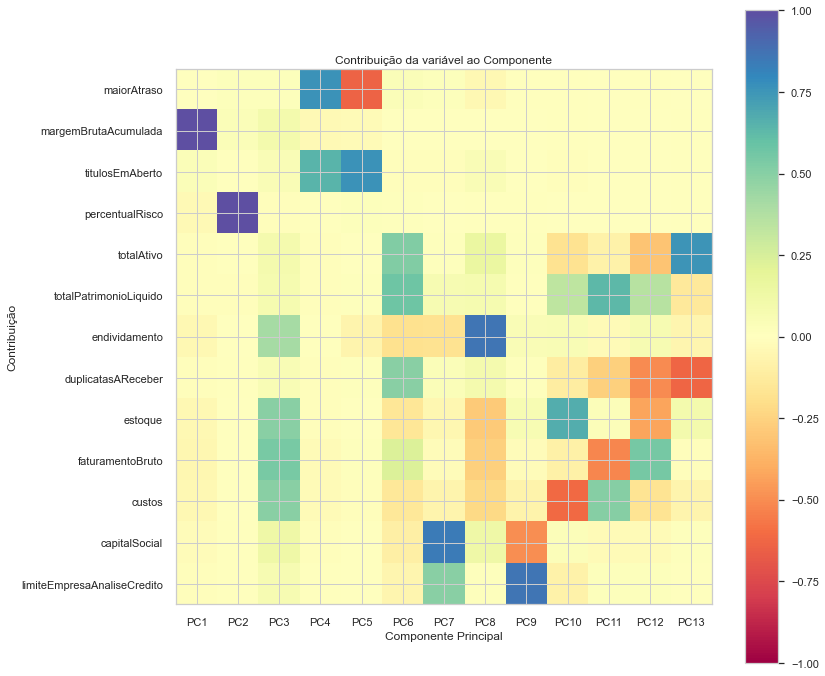

In [66]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.imshow(pca.components_.T, cmap="Spectral", vmin=-1, vmax=1)
plt.yticks(range(len(df_mmsc.columns)), df_mmsc.columns)
plt.xticks(range(len(df_pca.columns)), df_pca.columns)
plt.xlabel("Componente Principal")
plt.ylabel("Contribuição")
plt.title("Contribuição da variável ao Componente")
plt.colorbar()

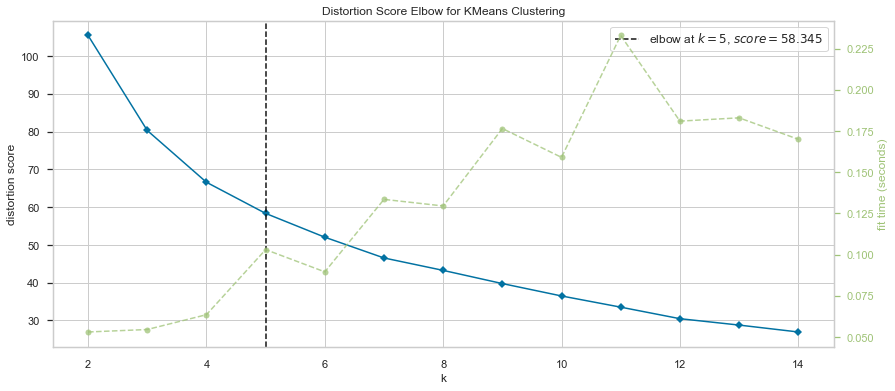

In [67]:
fig = plt.figure(figsize=(14,6))

model = KMeans(random_state=42)
distortion_visualizer = KElbowVisualizer(model, k=(2,15))

distortion_visualizer.fit(df_mmsc)       
distortion_visualizer.show()
plt.show()

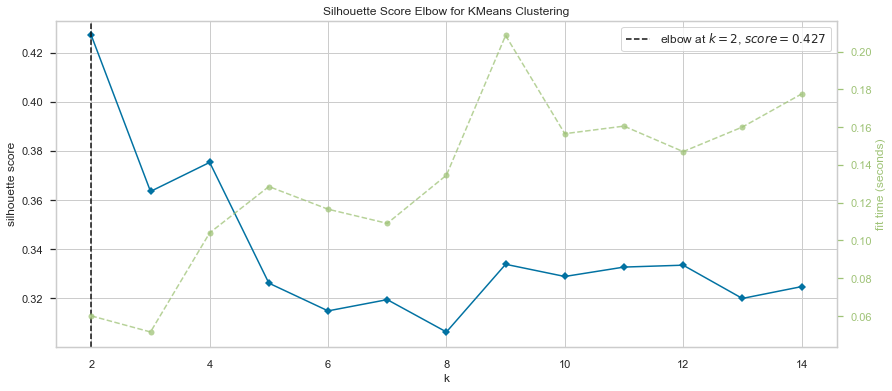

In [68]:
fig = plt.figure(figsize=(14,6))

model = KMeans(random_state=42)
distortion_visualizer = KElbowVisualizer(model, metric='silhouette',k=(2,15))

distortion_visualizer.fit(df_mmsc)       
distortion_visualizer.show()
plt.show()

In [69]:
km = KMeans(n_clusters=5, n_init=100, max_iter=1000, algorithm='full', random_state=42)
km_labels = km.fit_predict(df_mmsc)

In [70]:
df_num['kmeans'] = km_labels
df_mmsc['kmeans'] = km_labels
df_pca['kmeans'] = km_labels
df['kmeans'] = km_labels

In [71]:
df.groupby('kmeans').maiorAtraso.count()

kmeans
0    396
1    346
2    455
3    317
4      9
Name: maiorAtraso, dtype: int64

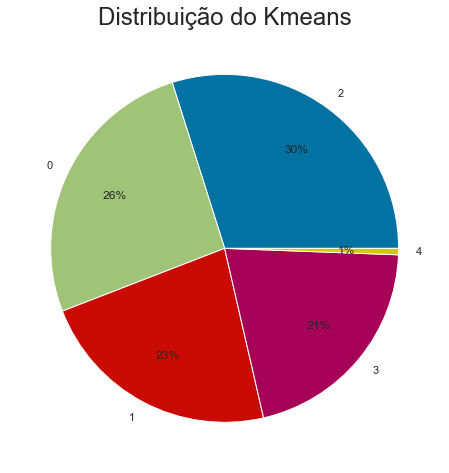

In [72]:
fig = plt.figure(figsize=(8,8))
df.kmeans.value_counts().plot.pie(autopct='%1.0f%%', pctdistance=0.7, labeldistance=1.1)
plt.title('Distribuição do Kmeans', size=24)
plt.ylabel("")
plt.show()

In [73]:
with pd.ExcelWriter("df_ex1_excel.xlsx") as writer:
    df.to_excel(writer)

In [74]:
#km_centroides = pd.DataFrame(mmsc.inverse_transform(pca.inverse_transform(km.cluster_centers_)))
km_centroides = pd.DataFrame(mmsc.inverse_transform(km.cluster_centers_))
km_centroides

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,19.212121,5.552564e-01,5.921485e+04,0.186465,4.136393e+07,1.829431e+07,2.533204e+06,8.355144e+06,9.778727e+06,5.999845e+07,2.799309e+07,9.505950e+06,2.165161e+06
1,15.199422,1.120357e-02,5.262880e+02,0.219624,2.261777e+08,8.419959e+07,3.095617e+06,6.932649e+07,1.153725e+07,8.102466e+07,4.229570e+07,2.517423e+07,7.994950e+06
2,31.153846,3.579131e-01,6.134978e+04,0.143615,2.503966e+07,1.119868e+07,1.839253e+06,7.214804e+06,6.849538e+06,4.496287e+07,2.304434e+07,5.728596e+06,2.292762e+06
3,24.536278,4.145452e-01,3.403236e+04,0.382047,1.082471e+07,3.217270e+06,1.143173e+06,2.505522e+06,2.482773e+06,2.264390e+07,8.617533e+06,7.361413e+06,8.326958e+05
4,44.444444,5.551115e-17,4.920814e-12,0.283730,4.087452e+09,7.741715e+08,4.581102e+08,7.147530e+08,7.918398e+08,3.975094e+09,2.765343e+09,8.499194e+08,1.540926e+08


In [75]:
with pd.ExcelWriter("Kmeans_centroides.xlsx") as writer:
    km_centroides.to_excel(writer)
    
df.to_csv("./df_ex1.csv", index=False)        

In [76]:
matriz = np.empty(km_centroides.shape)

for idc in range(km_centroides.shape[0]):
    for idx in range(km_centroides.shape[1]):
        num = [x for x in df_num.iloc[:,idx] if x < km_centroides.iloc[idc,idx]]
        num = round((len(num) / df_num.shape[0] *100), 2)
        matriz[idc,idx] = num
    

In [77]:
df_percentual = pd.DataFrame(matriz, columns=df_num.drop(['kmeans'], axis=1).columns)
df_percentual

,maiorAtraso,margemBrutaAcumulada,titulosEmAberto,percentualRisco,totalAtivo,totalPatrimonioLiquido,endividamento,duplicatasAReceber,estoque,faturamentoBruto,custos,capitalSocial,limiteEmpresaAnaliseCredito
0,74.39,85.69,90.48,40.64,88.51,88.51,88.05,83.91,87.39,87.72,86.87,94.55,85.69
1,68.88,21.34,62.44,53.91,96.19,96.26,89.10,97.05,88.90,90.22,90.28,96.39,93.63
2,83.72,43.86,90.68,33.62,83.32,84.04,85.69,82.01,83.65,84.64,85.16,93.30,86.08
3,79.71,56.27,85.95,89.56,72.36,67.50,82.47,69.47,69.40,75.64,74.79,94.16,78.92
4,87.72,21.21,62.38,70.91,99.80,99.28,99.67,99.80,99.80,99.74,99.74,99.54,99.74


In [45]:
with pd.ExcelWriter("Kmeans_percentual.xlsx") as writer:
    df_percentual.to_excel(writer)

# Avaliação do Modelo

Vamos usar duas métricas para avaliar o modelo, e depois analisar algugns gráficos

The Davis-Bouldin Index is the average similarity between each cluster and the closest cluster. Scores range from 0 and up. 0 indicates better clustering.
The Silhouette Coefficient is a value between -1 and 1. The higher the score, the better. 1 indicates tight clusters, and 0 means overlapping clusters.

In [122]:
print(f'Davies-Bouldin index = {davies_bouldin_score(df_pca, km_labels)}')
print(f'Silhouette Score = {silhouette_score(df_pca, km_labels)}')

Davies-Bouldin index = 0.2430952499928764
Silhouette Score = 0.8321200073303329


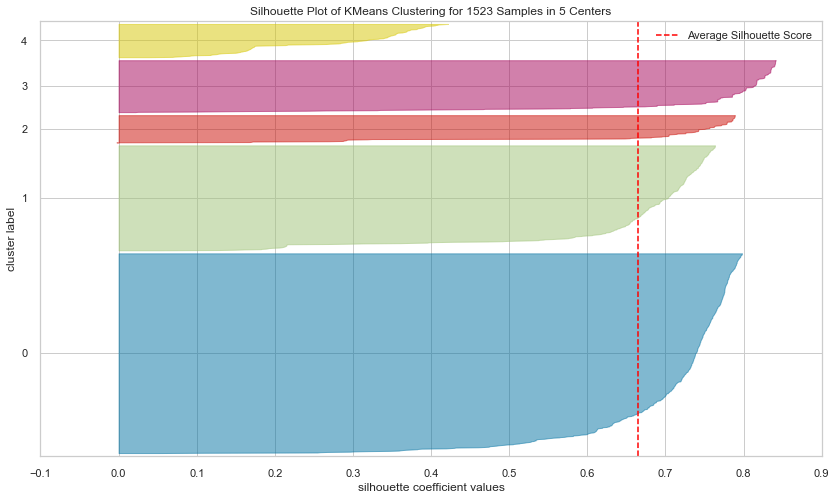

In [47]:
fig = plt.figure(figsize=(14,8))

visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
visualizer.fit(df_mmsc.drop(['kmeans'],axis=1))
visualizer.show()
plt.show()

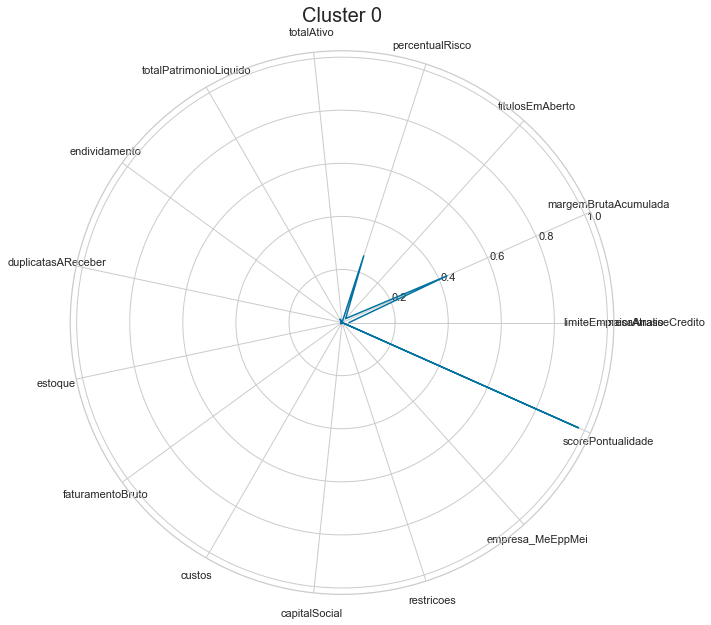

In [48]:
spider_plot_unico(df_mmsc, 0)

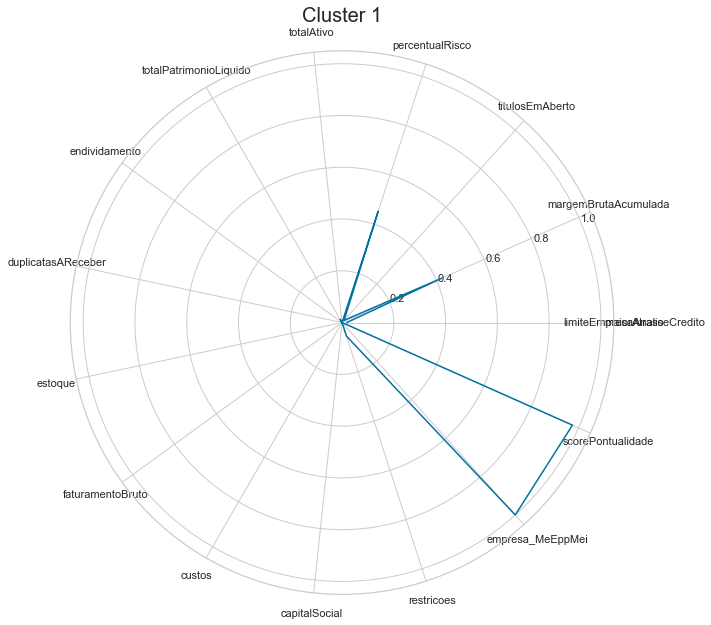

In [49]:
spider_plot_unico(df_mmsc, 1)

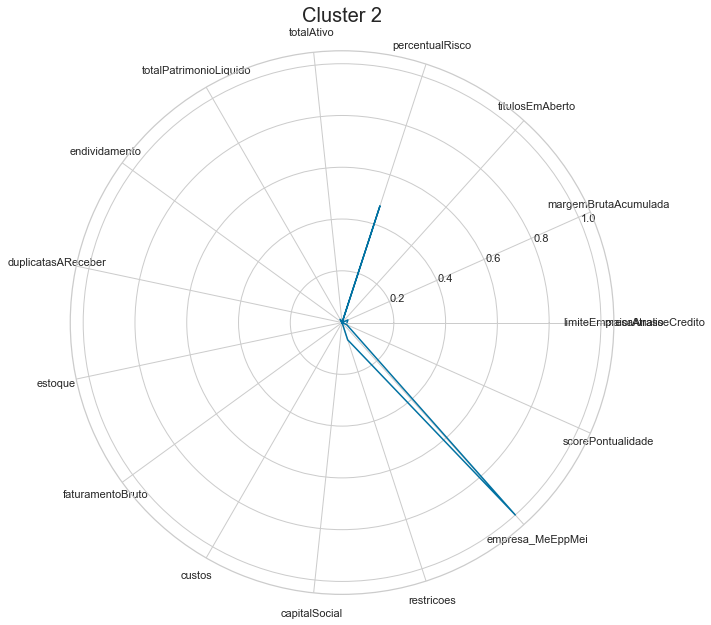

In [50]:
spider_plot_unico(df_mmsc, 2)

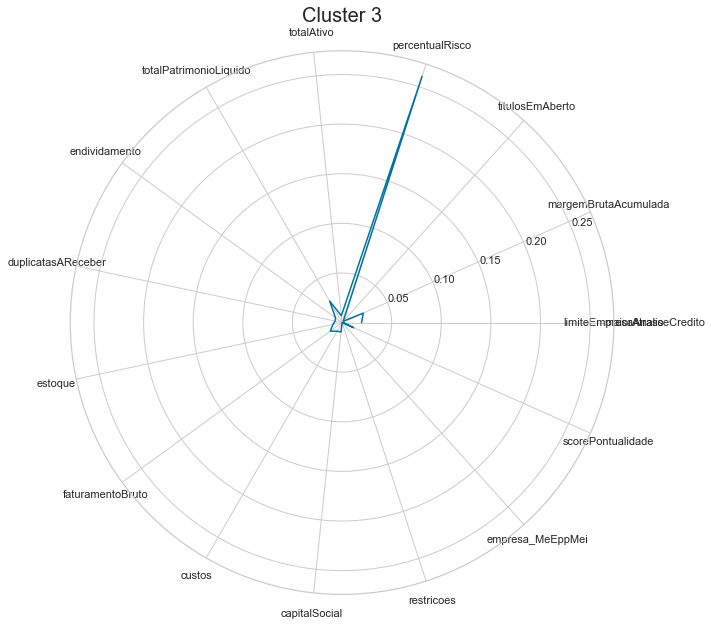

In [51]:
spider_plot_unico(df_mmsc, 3)

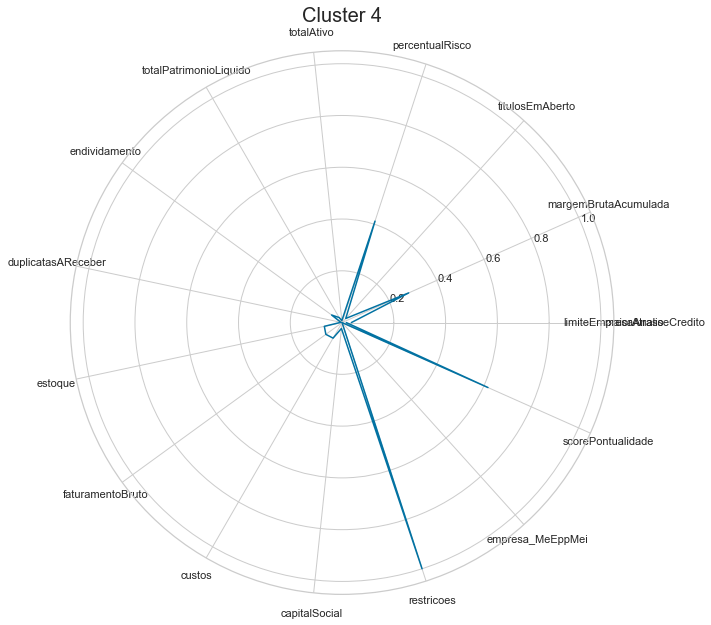

In [52]:
spider_plot_unico(df_mmsc, 4)